In [201]:
import os
import sys
import math
import matplotlib.pyplot as plt
import cv2

In [202]:
annotations_path = os.path.join('test', 'info.dat')

# Initialize an empty list to store annotations
annotations = []
num_pictures = 0

# Open the annotations file for reading
with open(annotations_path, 'r') as file:
    # Loop through the lines in the annotation file
    for i, line in enumerate(file):
        # Increment the line count
        num_pictures = i + 1

        # Split the line into values
        values = line.strip().split()

        # Check for the end of the annotations file
        if len(values) == 0:
            break

        # Get the image path and number of faces in the image
        img_path = values[0]
        face_index = 1

        # Error check the line to ensure it has the expected format
        try:
            num_faces = int(values[face_index])
        except ValueError:
            print(f'Line {i}: Warning: Skipping Line; Incorrect Format:')
            print(f'- Line: "{line.strip()}"')
            continue

        # Loop through every face in the picture
        for _ in range(num_faces):
            # Get the variables for face 'j' in the picture
            face_x = int(values[face_index + 1])
            face_y = int(values[face_index + 2])
            face_w = int(values[face_index + 3])
            face_h = int(values[face_index + 4])
            
            # Increment the face_index for the next face
            face_index += 4

            # Save the variables as a facebox
            annotation = {
                'filename': img_path,
                'x': face_x,
                'y': face_y,
                'w': face_w,
                'h': face_h
            }
            # Append the facebox to the list
            annotations.append(annotation)

# Print the result for debugging
print(f'Info: '
      f'Found {len(annotations)} face{"s" if len(annotations) > 1 else ""} '
      f'in {num_pictures} picture{"s" if num_pictures > 1 else ""}')

Info: Found 47 faces in 2 pictures


In [203]:
def calculate_center(box: dict[str, int]) -> tuple[int, int]:
    """Calculate the center of a bounding box."""
    x = round(box['x'] + box['w'] / 2)
    y = round(box['y'] + box['h'] / 2)
    return x, y

def calculate_distance(point1: tuple[int, int], point2: tuple[int, int]) -> float:
    """Calculate the Euclidean distance between two points."""
    x1, y1 = point1
    x2, y2 = point2
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def find_matching_annotation(annotations: list[dict[str, int]], detected: dict[str, int], error_threshold: float=0.25) -> tuple[bool, list[dict[str, any]]]:
    """Find and match the closest annotation to a detected face."""
    detected_center = calculate_center(detected)

    # Find the closest label
    minimum_distance = sys.float_info.max
    minimum_index = None
    for i, annotation in enumerate(annotations):
        annotation_center = calculate_center(annotation)
        distance = calculate_distance(detected_center, annotation_center)
        if distance < minimum_distance:
            minimum_distance = distance
            minimum_index = i

    # If there were no labels, return False
    if minimum_index is None:
        return False, annotations
    
    # Calculate the distance requirement based on the size of the annotation
    annotation = annotations[minimum_index]
    allowed_distance = (annotation['h'] / 2) * error_threshold if annotation['h'] > annotation['w'] else (annotation['w'] / 2) * error_threshold

    # Check if the distance abides
    if minimum_distance < allowed_distance:
        # If distance is within the limit, remove the matched label
        del annotations[minimum_index]
        return True, annotations
    else:
        # If distance is too large, keep the label
        return False, annotations

def draw_rectangle(image: cv2.Mat, box: cv2.Mat, color: tuple[int, int, int]=(0, 255, 0), thickness: int=1) -> None:
    """Draw a rectangle on the image."""
    x, y, w, h = box['x'], box['y'], box['w'], box['h']
    cv2.rectangle(image, (x, y), (x+w, y+h), color, thickness)

def evaluate_model(detect_callback, labels: list[dict[str, any]], detection_threshold: int=0.25) -> dict[str, dict[str, any]]:
    """Evaluate a face detection model."""
    results = {}

    # Iterate through every label
    for label in labels:
        img_path = label['filename']
        if img_path in results:
            continue

        # Setup the evaluation metrics
        TP, FP, FN = 0, 0, 0

        # Get every annotation associated with the image
        annotations = [annotation for annotation in labels if annotation.get('filename') == img_path]

        # Detect faces in the test image using the provided callback
        img = cv2.imread(img_path)
        detected = detect_callback(img)

        # Match every detected face with the annotations
        image_size = len(img) if len(img) > len(img[0]) else len(img[0])
        thickness = math.ceil(image_size / 1250)
        for box in detected:
            ret, annotations = find_matching_annotation(annotations, box, detection_threshold)
            if ret:
                # Detected face matches annotation (True Positive)
                draw_rectangle(img, box, (0, 255, 0), thickness)
                TP += 1
            else:
                # Detected face does not match annotation (False Positive)
                draw_rectangle(img, box, (0, 255, 255), thickness)
                FP += 1

        # Remaining annotations were not detected (False Negative)
        FN = len(annotations)
        for annotation in annotations:
            draw_rectangle(img, annotation, (0, 0, 255), thickness)
        
        # Add the metrics to the result
        results[img_path] = {'Image': img, 'TP': TP, 'FP': FP, 'FN': FN}

    return results

def get_image_paths(evaluation_results: dict[str, dict[str, any]]) -> list[str]:
    """Gets filenames from evaluation results"""
    return list(evaluation_results.keys())

In [204]:
def display_single_image(image_info):
    """Display one image from the given image_info dictionary using Matplotlib."""
    # Set a fixed figure size for a single image
    fig_width = 8
    fig_height = 8

    # Create a single subplot
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))

    # Display the image
    img = image_info['Image']
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)

    # Set the title with a bigger font size
    ax.set_title(f"Score: [TP: {image_info['TP']}, FP: {image_info['FP']}, FN: {image_info['FN']}]")
    ax.axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

## Evaluation - Yunet

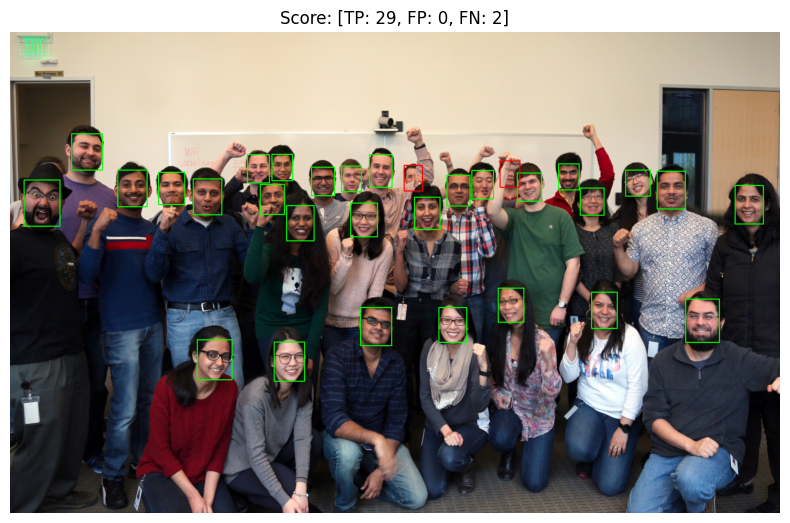

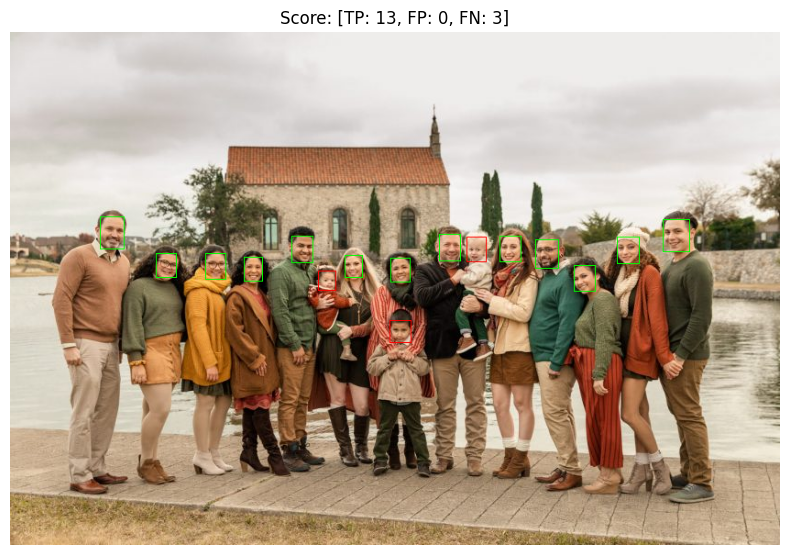

In [205]:
# Initialize the yunet model
yunet_model_path = os.path.join('models', 'yunet.onnx')
yunet = cv2.FaceDetectorYN.create(
    model=      yunet_model_path,
    config=     "",
    input_size= (0, 0)
)

# Define a detect callback function that delivers the result in the required format
def yunet_detect(img: cv2.Mat) -> list[dict[str, int]]:
    yunet.setInputSize((img.shape[1], img.shape[0]))
    _, faces = yunet.detect(img)
    result = []
    for face in faces:
        result.append({
            'x': int(face[0]),
            'y': int(face[1]),
            'w': int(face[2]),
            'h': int(face[3])
        })
    return result

# Perform the evaluation on yunet
evaluation_results = evaluate_model(yunet_detect, annotations)
image_paths = get_image_paths(evaluation_results)

# Display the classified images
for path in image_paths:
    display_single_image(evaluation_results[path])

## Evaluation - Haar Face Cascade (OpenCV)

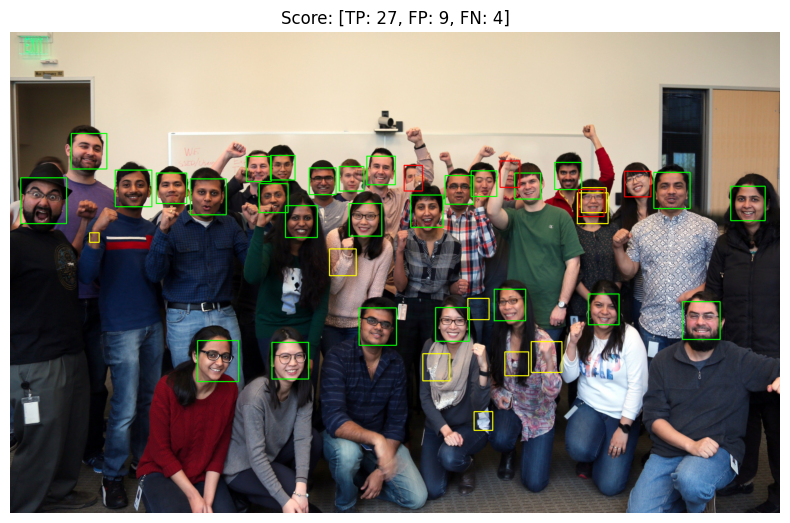

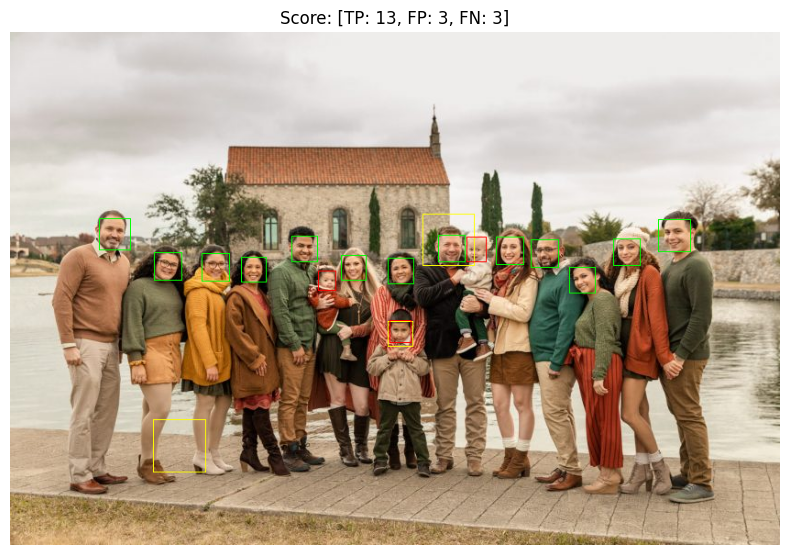

In [206]:
# Initialize the haar cascade model
face_cascade_model_path = os.path.join('models', 'cascade_opencv.xml')
face_cascade = cv2.CascadeClassifier(face_cascade_model_path)

# Define a detect callback function that delivers the result in the required format
def cascade_detect(img: cv2.Mat) -> list[dict[str, int]]:
    faces = face_cascade.detectMultiScale(img)
    result = []
    for face in faces:
        result.append({
            'x': int(face[0]),
            'y': int(face[1]),
            'w': int(face[2]),
            'h': int(face[3])
        })
    return result

# Perform the evaluation on haar cascade
evaluation_results = evaluate_model(cascade_detect, annotations)

# Display the classified images
for path in image_paths:
    display_single_image(evaluation_results[path])